##### Copyright 2020 The IREE Authors

In [1]:
#@title Licensed under the Apache License v2.0 with LLVM Exceptions.
# See https://llvm.org/LICENSE.txt for license information.
# SPDX-License-Identifier: Apache-2.0 WITH LLVM-exception

# ResNet

[ResNet](https://arxiv.org/abs/1512.03385) is a deep neural network architecture for image recognition.

This notebook

* Constructs a [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50) model using `tf.keras`, with weights pretrained using the[ImageNet](http://www.image-net.org/) dataset
* Compiles that model with IREE
* Tests TensorFlow and IREE execution of the model on a sample image

In [2]:
%%capture
!python -m pip install --upgrade tf-nightly  # Needed for stablehlo export in TF>=2.14

In [3]:
!python -m pip install iree-compiler iree-runtime iree-tools-tf -f https://openxla.github.io/iree/pip-release-links.html

Looking in links: https://openxla.github.io/iree/pip-release-links.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 47.5 MB/s eta 0:00:00


In [4]:
#@title Imports and common setup

from iree import runtime as ireert
from iree.tf.support import module_utils

import tensorflow as tf
from matplotlib import pyplot as plt

# Print version information for future notebook users to reference.
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.15.0-dev20230831


In [5]:
#@title Construct a pretrained ResNet model with ImageNet weights

# Static shape, including batch size (1).
# Can be dynamic once dynamic shape support is ready.
INPUT_SHAPE = [1, 224, 224, 3]

tf_model = tf.keras.applications.resnet50.ResNet50(
    weights="imagenet", include_top=True, input_shape=tuple(INPUT_SHAPE[1:]))

# Wrap the model in a tf.Module to compile it with IREE.
class ResNetModule(tf.Module):

  def __init__(self):
    super(ResNetModule, self).__init__()
    self.model = tf_model

  @tf.function(input_signature=[tf.TensorSpec(INPUT_SHAPE, tf.float32)])
  def predict(self, x):
    return self.model.call(x, training=False)

102967424/102967424 [==============================] - 2s 0us/step


In [6]:
#@markdown ### Backend Configuration

backend_choice = "iree_llvmcpu (CPU)" #@param [ "iree_vmvx (CPU)", "iree_llvmcpu (CPU)", "iree_vulkan (GPU/SwiftShader)" ]
backend_choice = backend_choice.split(" ")[0]
backend = module_utils.BackendInfo(backend_choice)

In [7]:
#@title Compile ResNet with IREE
# This may take a few minutes.
iree_module = backend.compile_from_class(ResNetModule, ["predict"])

/usr/local/lib/python3.10/dist-packages/iree/tf/support/module_utils.py:425: UserWarning: Making copy of unaligned VmModule buffer. It is recommended to make this deterministic by calling `copy_buffer` to always make a copy or `mmap` to efficiently load from a file. This warning can be silenced by adding `warn_if_copy=False` to `from_buffer`
  vm_module = iree.runtime.VmModule.from_flatbuffer(


83281/83281 [==============================] - 0s 0us/step
Test image:


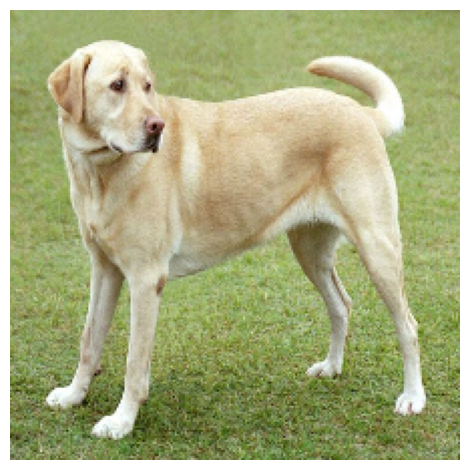

In [8]:
#@title Load a test image of a [labrador](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg)

def load_image(path_to_image):
  image = tf.io.read_file(path_to_image)
  image = tf.image.decode_image(image, channels=3)
  image = tf.image.resize(image, (224, 224))
  image = image[tf.newaxis, :]
  return image

content_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_image = load_image(content_path)

print("Test image:")
plt.imshow(content_image.numpy().reshape(224, 224, 3) / 255.0)
plt.axis("off")
plt.tight_layout()

In [9]:
#@title Model pre- and post-processing
input_data = tf.keras.applications.resnet50.preprocess_input(content_image)

def decode_result(result):
  return tf.keras.applications.resnet50.decode_predictions(result, top=3)[0]

In [10]:
#@title Run TF model

print("TF prediction:")
tf_result = tf_model.predict(input_data)
print(decode_result(tf_result))

TF prediction:
35363/35363 [==============================] - 0s 0us/step
[('n02091244', 'Ibizan_hound', 0.12879114), ('n02099712', 'Labrador_retriever', 0.12632973), ('n02091831', 'Saluki', 0.09625238)]


In [11]:
#@title Run the model compiled with IREE

print("IREE prediction:")
iree_result = iree_module.predict(input_data)
print(decode_result(iree_result))

IREE prediction:
[('n02091244', 'Ibizan_hound', 0.12879086), ('n02099712', 'Labrador_retriever', 0.12632956), ('n02091831', 'Saluki', 0.09625253)]
